# Table of Contents

* [Import packages](#Packages)
* [Import Brain Matrix and Find Number of Pixels in Each Brain](#Pixels_in_brain)
* [Import Sums of Pixels](#Union)
* [Final Thresholding Using Union of All Sample Thresholds](#Thresholding_union)

<a class="anchor" id="Packages"></a>

In [8]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Package for fitting normal distribution
from scipy.stats import norm

<a class="anchor" id="Pixels_in_brain"></a>
Below we find the number of pixels in each brain so we can normalize each sum by the brain size.

In [5]:
number_pixels_list_whole_brain = []

brain_matrix_without_background = pd.read_csv('225_a1wt_pixel_matrix_with_mask_whole_brain.csv', index_col = 0)
number_pixels_list_whole_brain.append(len(brain_matrix_without_background[brain_matrix_without_background.sum(axis = 1) != 0]))

<a class="anchor" id="Union"></a>
Below we read in all the total sums we saved from the brain segmentations. We also divide each sum by the number of pixels corresponding to that sum.

In [6]:
sums_of_ion_intensities_roi_225_a1wt_whole_brain_df = pd.read_csv('225_a1wt_sum_of_ions_within_whole_brain.csv', index_col = 0)
sums_of_ion_intensities_roi_normalized_225_a1wt_whole_brain_df = sums_of_ion_intensities_roi_225_a1wt_whole_brain_df/number_pixels_list_whole_brain[0]

<a class="anchor" id="Thresholding_union"></a>
# Thresholding on the sample
Below we run the thresholding for all the files and create a cutoff for each file based on the first and second standard deviations from the mean of the distribution of ions. In this case we add np.abs() since our number of ions is much smaller than the untargeted data files used in the experiment. This is not added when there is a large amount of ions.

In [31]:
# Log data
logged_data_225_a1wt = np.log(sums_of_ion_intensities_roi_normalized_225_a1wt_whole_brain_df[sums_of_ion_intensities_roi_normalized_225_a1wt_whole_brain_df['0'] > 0])
# Fit normal distribution and find mean and std
mu_225_a1wt, std_225_a1wt = norm.fit(logged_data_225_a1wt)
# Find all values that are greater than one std
theshold_one_std_225_a1wt = logged_data_225_a1wt[np.abs(logged_data_225_a1wt['0']) > (mu_225_a1wt + std_225_a1wt)]
# Take ions that pass filtering
theshold_one_std_index_225_a1wt = theshold_one_std_225_a1wt.index.tolist()
# Find all values that are greater than two std
theshold_two_std_225_a1wt = logged_data_225_a1wt[np.abs(logged_data_225_a1wt['0']) > (mu_225_a1wt + 2*std_225_a1wt)]
# Take ions that pass filtering
theshold_two_std_index_225_a1wt = theshold_two_std_225_a1wt.index.tolist()
# Convert list to character to match the dtype of the columns of the metabolomics matrix
theshold_two_std_index_225_a1wt = list(map(str, theshold_two_std_index_225_a1wt))

Below we show all the ions because we want to filter out those that are noise.

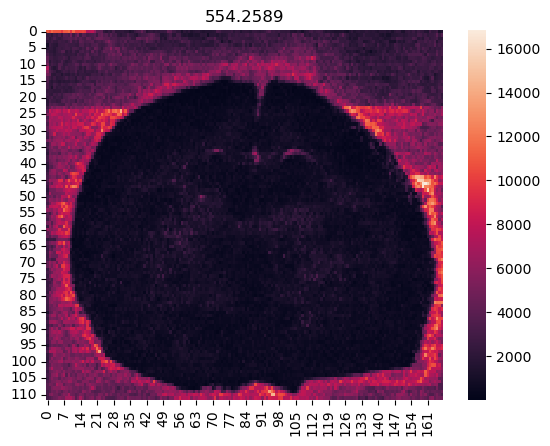

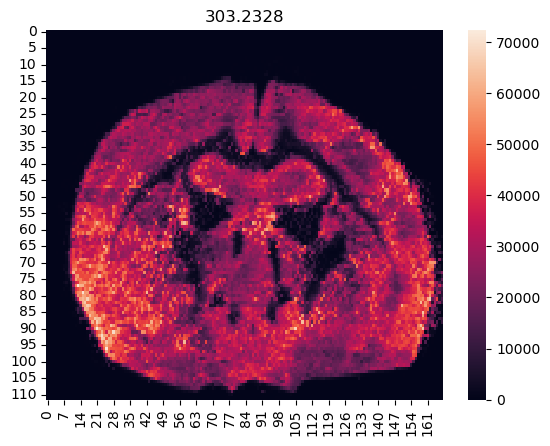

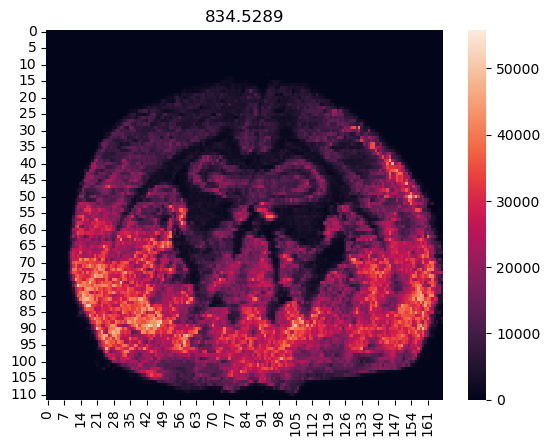

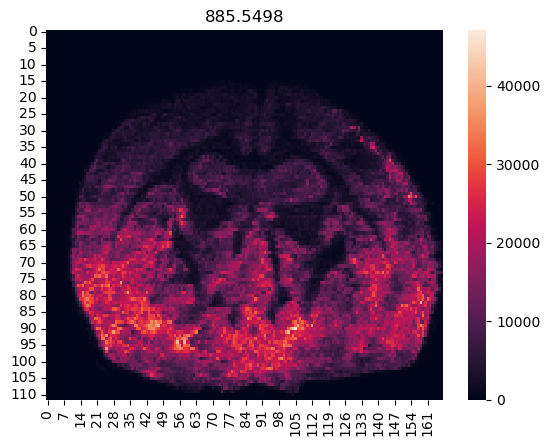

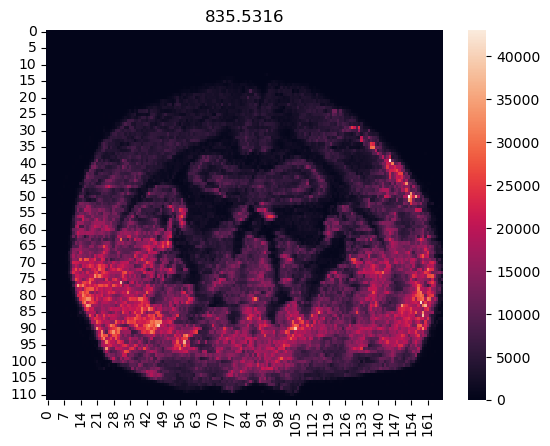

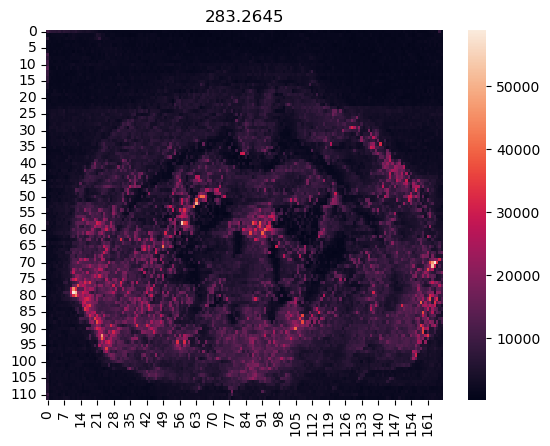

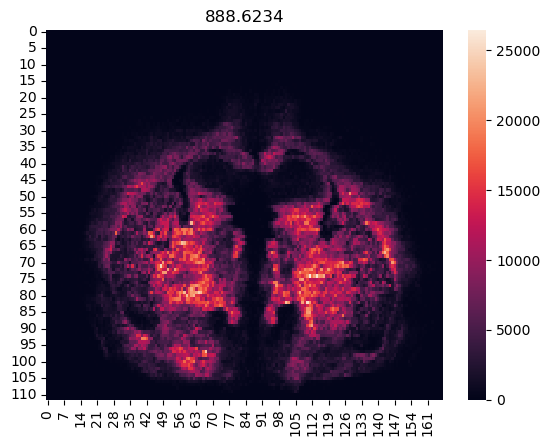

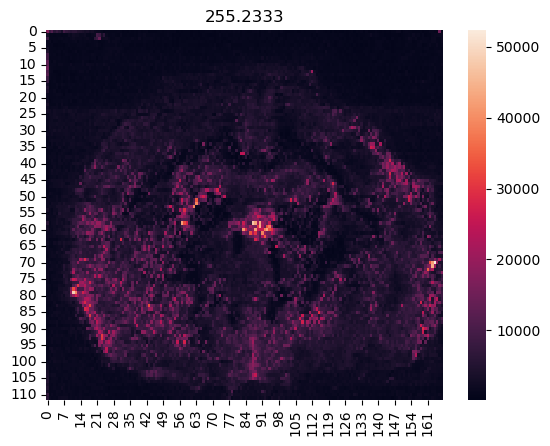

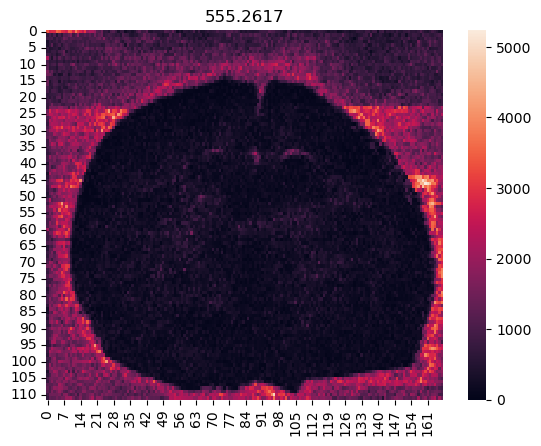

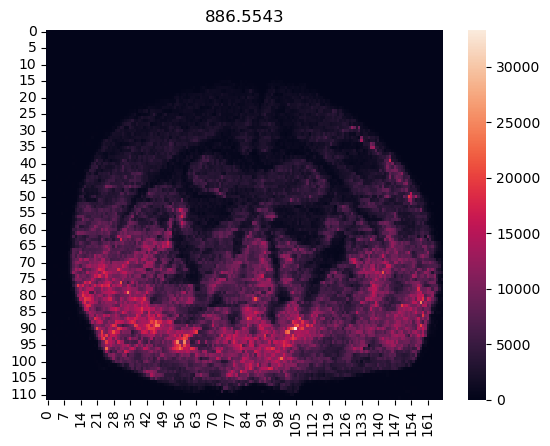

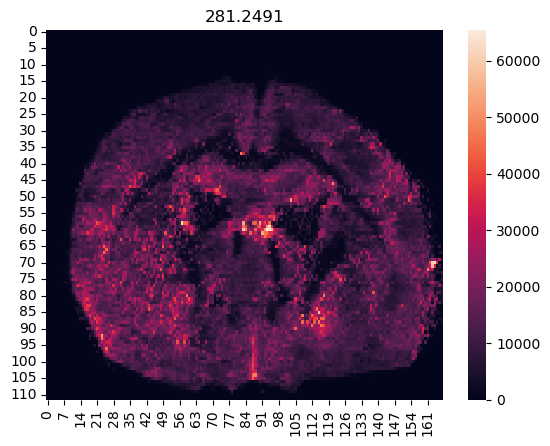

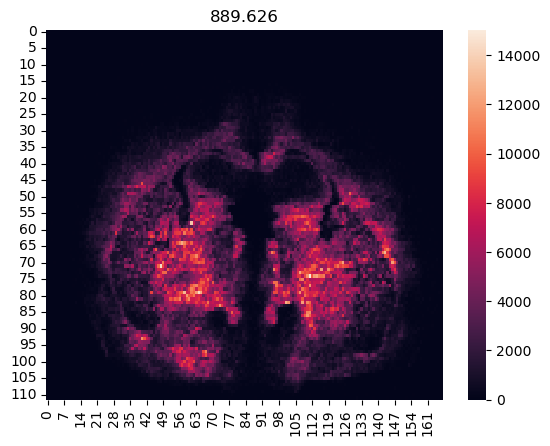

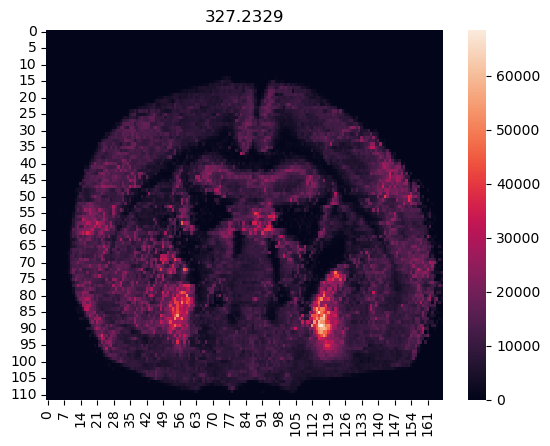

In [32]:
# Import one full brain matrix
num_metabolites_negative = 13
# Import metabolomics matrix only
metabolomics_matrix_225_a1wt = pd.read_csv('225_a1wt_subsampled.txt', sep = '\t', usecols = [i for i in range(3, num_metabolites_negative+3)], header = 2)
# Drop retention time
metabolomics_matrix_225_a1wt = metabolomics_matrix_225_a1wt.drop(0)
# Reset index to start with 0
metabolomics_matrix_225_a1wt = metabolomics_matrix_225_a1wt.reset_index(drop = True)
# Read in coordinates for metabolomics matrix
coordinates_matrix_225_a1wt = pd.read_csv('225_a1wt_subsampled.txt', sep = '\t', usecols = [i for i in range(1,3)], skiprows = 4, names = ['x_coord', 'y_coord'])

# Plot all ions in list
for i in theshold_two_std_index_225_a1wt:
    uniform_data_225_a1wt = np.array(metabolomics_matrix_225_a1wt).T.reshape([num_metabolites_negative, len(coordinates_matrix_225_a1wt[coordinates_matrix_225_a1wt['x_coord'] == coordinates_matrix_225_a1wt.iloc[0][0]]), len(coordinates_matrix_225_a1wt[coordinates_matrix_225_a1wt['y_coord'] == coordinates_matrix_225_a1wt.iloc[0][1]])])[metabolomics_matrix_225_a1wt.columns.get_loc(i)]
    ax = sns.heatmap(uniform_data_225_a1wt)
    plt.title(i)
    plt.show()

Below we manually currate a list of ions that need to be removed from our ion list since they are just noise. We find 2 ions that are noise!

In [34]:
noise_ions = ['554.2589', '555.2617']
print('Number of filtered ions:', len(noise_ions))
#noise_ions_float = [float(i) for i in noise_ions]
theshold_two_std_index_225_a1wt_without_noise_ions = [x for x in theshold_two_std_index_225_a1wt if x not in noise_ions]
len(theshold_two_std_index_225_a1wt_without_noise_ions)

Number of filtered ions: 2


11

Below we save these two lists as dataframes.

In [35]:
pd.DataFrame(theshold_two_std_index_225_a1wt_without_noise_ions).to_csv('two_sd_filtered_ions_no_noise.csv')